In [1]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from classification_tree import ClassificationTree

In [2]:
random.seed(10)

In [3]:
n_of_classes = 2

## Příprava dat

In [4]:
data = load_breast_cancer()

In [5]:
X = data['data']
y = data['target']
print("X example: ", X[:2])
print("y example: ", y[:2])
print(data['target_names'])

X example:  [[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 1.326e+03 8.474e-02 7.864e-02 8.690e-02
  7.017e-02 1.812e-01 5.667e-02 5.435e-01 7.339e-01 3.398e+00 7.408e+01
  5.225e-03 1.308e-02 1.860e-02 1.340e-02 1.389e-02 3.532e-03 2.499e+01
  2.341e+01 1.588e+02 1.956e+03 1.238e-01 1.866e-01 2.416e-01 1.860e-01
  2.750e-01 8.902e-02]]
y example:  [0 0]
['malignant' 'benign']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=10)

Volit 0.5 jako velikost test setu je velmi velkorysé. Tak proč jsem se tak rozhodl? Breast cancer dataset má problém, že je tak jednoduchý, že i jeden samotný strom dokáže dosáhnout téměř bezchybných výsledků, pokud mu poskytneme k trénování cca 80 % všech dat. Porovnávat takový strom s náhodným lesem není příliš zajímavé, protože les může být jen o malinko lepší.

In [7]:
dim_red = PCA(n_components=2).fit_transform(X_train)

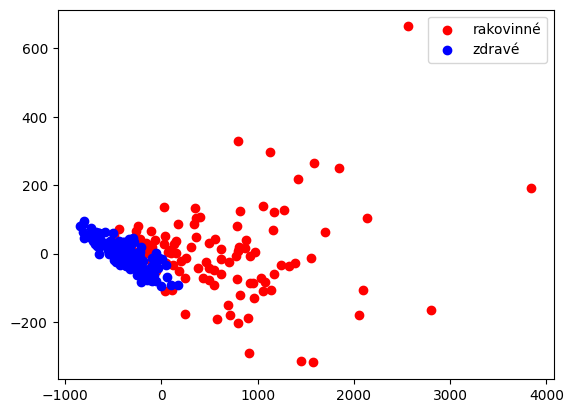

In [8]:
class_0 = dim_red[y_train == 0]
class_1 = dim_red[y_train == 1]

# Create a scatter plot
plt.scatter(class_0[:, 0], class_0[:, 1], c='red', label='rakovinné', marker='o')
plt.scatter(class_1[:, 0], class_1[:, 1], c='blue', label='zdravé', marker='o')


plt.legend()

plt.show()

Vidíme celkem intuitivní věc, že nezhoubné novotvary jsou si podobné a nijak nevyčnívají, naopak rakoviné dokážou být hodně divoké a rozdílné. Jednoduchá projekce do 2D nedokáže útvary spolehlivě rozdělit, pojďme se podívat, jak to zvládnou rozhodovací stromy a náhodné lesy. 

## Pomocné funkce

In [9]:
def accuracy(p, t):
    assert len(p) == len(t)
    return round(sum(p == t) / len(p) * 100, 2)

## Samotný rozhodovací strom

In [10]:
dt = ClassificationTree(n_of_classes=n_of_classes, max_depth=4)
dt.fit(X_train, y_train)

In [11]:
# V notebooku nebudeme řešit žádná rozdělení, predikce bude vždy jedna konkrétní třída:
p = dt.hard_predict(X_test)
print(p[:5])

[0, 1, 1, 0, 1]


In [12]:
print(f"Accuracy: {accuracy(p, y_test)} %")

Accuracy: 95.09 %


## Více stromů

In [13]:
class FakeRandomForest:
    def __init__(self, n_of_trees, n_of_classes, max_depth):
        self.trees = [ClassificationTree(n_of_classes, max_depth) for _ in range(n_of_trees)]

    def fit(self, X, y):
        for t in self.trees:
            t.fit(X, y)

    def hard_predict(self, X):
        preds = [t.hard_predict(X) for t in self.trees]
        counts = [np.bincount(sample) for sample in zip(*preds)]
        return [np.argmax(c) for c in counts]

In [14]:
n_of_trees = 100
frf = FakeRandomForest(n_of_trees, n_of_classes=n_of_classes, max_depth=4)
frf.fit(X_train, y_train)

In [15]:
# V notebooku nebudeme řešit žádná rozdělení, predikce bude vždy jedna konkrétní třída:
p = frf.hard_predict(X_test)
print(p[:5])

[0, 1, 1, 0, 1]


In [16]:
print(f"Accuracy: {accuracy(p, y_test)} %")

Accuracy: 95.09 %


**Nic se nezměnilo!** Stavba stromů je deterministická. Každý strom v lese je stejný, takže výsledek se neliší od situace, kdy máme jen jeden strom. Proto potřebujeme vytvořit rozdílné stromy, i když to bude znamenat, že některé stromu sami o sobě nebudou tak dobré.

## Bootstrap aggregating

Pro každý strom vytvoříme vlastní dataset a to velice primitivním přístupem. Datasety budou různé a tím se zajistí i různost stromů. Jak vytvořit různé dataset? Řekněme, že původní dataset má N příkladů. Chceme-li, aby každý strom měl nový dataset o N příkladech, tak prostě z původního datasetu N-krát vybereme a získáme tak nový. Všimněte si, že můžeme do jednoho datasetu klidně vybrat vícekrát ten samý příklad.

In [17]:
class BaggingForest:
    def __init__(self, n_of_trees, n_of_classes, max_depth):
        self.trees = [ClassificationTree(n_of_classes, max_depth) for _ in range(n_of_trees)]

    def fit(self, X, y):
        all_indices = list(range(len(X)))
        for t in self.trees:
            bagged_indices = [random.choice(all_indices) for _ in range(len(X))]
            t.fit(X[bagged_indices], y[bagged_indices])

    def hard_predict(self, X):
        preds = [t.hard_predict(X) for t in self.trees]
        counts = [np.bincount(sample) for sample in zip(*preds)]
        return [np.argmax(c) for c in counts]

In [18]:
n_of_trees = 100
bf = BaggingForest(n_of_trees, n_of_classes=n_of_classes, max_depth=4)
bf.fit(X_train, y_train)

In [19]:
# V notebooku nebudeme řešit žádná rozdělení, predikce bude vždy jedna konkrétní třída:
p = bf.hard_predict(X_test)
print(p[:5])

[0, 1, 1, 0, 1]


In [20]:
print(f"Accuracy: {accuracy(p, y_test)} %")

Accuracy: 96.84 %


Tohle vypadá trochu lépe, přesto to není všechno a ukážeme si ještě druhý trik jak stromy znáhodnit.

## Feature subsampling -- opravdový náhodný les

O co jde? Doposud mohl rozhodovací strom pracovat se všemi vlastnostmi v datech. My ho uděláme ještě náhodnější tím, že při každém rozdělování dovolíme jen několik náhodný vlastností a na jiných mu dělení zakážeme. 

In [21]:
# Tradičně se dovoluje sqrt, nebo log_2 celkového počtu vlastností
ftrs_to_allow_f = lambda x: int(np.sqrt(x))

In [22]:
def ftr_gen(ftrs_to_allow_f, n_of_ftrs):
    ftrs = list(range(n_of_ftrs))
    random.shuffle(ftrs)
    for i in range(ftrs_to_allow_f(n_of_ftrs)):
        yield ftrs[i]

In [23]:
class RandomForest:
    def __init__(self, n_of_trees, ftr_gen, n_of_classes, max_depth):
        self.trees = [ClassificationTree(n_of_classes, max_depth, ftr_gen) for _ in range(n_of_trees)]

    def fit(self, X, y):
        all_indices = list(range(len(X)))
        for t in self.trees:
            bagged_indices = [random.choice(all_indices) for _ in range(len(X))]
            t.fit(X[bagged_indices], y[bagged_indices])

    def hard_predict(self, X):
        preds = [t.hard_predict(X) for t in self.trees]
        counts = [np.bincount(sample) for sample in zip(*preds)]
        return [np.argmax(c) for c in counts]

In [24]:
n_of_trees = 100
rf = RandomForest(n_of_trees, partial(ftr_gen, ftrs_to_allow_f), n_of_classes=n_of_classes, max_depth=4)
rf.fit(X_train, y_train)

In [25]:
# V notebooku nebudeme řešit žádná rozdělení, predikce bude vždy jedna konkrétní třída:
p = rf.hard_predict(X_test)
print(p[:5])

[0, 1, 1, 0, 1]


In [26]:
print(f"Accuracy: {accuracy(p, y_test)} %")

Accuracy: 97.19 %


## GradientBoostedDecisionTrees

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
n_of_trees = 100
gbdt = GradientBoostingClassifier(n_estimators=n_of_trees, max_depth=4)
gbdt.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4)

In [29]:
# V notebooku nebudeme řešit žádná rozdělení, predikce bude vždy jedna konkrétní třída:
p = gbdt.predict(X_test)
print(p[:5])

[0 1 1 0 1]


In [30]:
print(f"Accuracy: {accuracy(p, y_test)} %")

Accuracy: 98.25 %


In [34]:
n_of_trees = 1000
gbdt = GradientBoostingClassifier(n_estimators=n_of_trees, max_depth=2)
gbdt.fit(X_train, y_train)
p = gbdt.predict(X_test)
print(f"Accuracy: {accuracy(p, y_test)} %")

Accuracy: 98.6 %
